<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/tutorials/P4.1_Node_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P4.1: Node Classification (using Graph Neural Networks)
In this tutorial we will explore Graph Neural Networks (GNNs) and apply them to
the task of classifying individual nodes in a graph. To do so, we will use
PyTorch and the PyTorch Geometric library. PyTorch Geometric is an extension
that implements deep learning methods based on graphs and other irregular
structures, allowing us to explore such networks without having to code
everything by hand (see [[1]](#pytorchgeomintro) for more information).

The main (learning) objectives of this tutorial are as follows:

*   Providing a short overview of graphs/graph data and the problem of
    classifying nodes in a graph.
*   How to structure graph data (for PyTorch Geometric specifically - although
    the general concept extends to arbitrary libraries/implementations).
*   Providing an overview of the general structure of GNNs, alongside a
    discussion of the specific GNN-variant we use,
    GraphSAGE[[2]](#hamilton2017).
*   How to build a GNN, and showing what the advantage is of incorporating the
    graph structure into the model.
*   How to train a GNN with the goal of classifying nodes.

#  Preparation
To start, we install the necessary packages (that are not pre-installed on the
Google Colab environment), set up the formatting of cells in the notebook and
download the (meta)data we consider in this tutorial.

In [ ]:
# PyTorch Geometric is not part of the standard Colab packages; we must
# install it ourselves.
!pip install torch_geometric

# PyTorch Geometric version 2.5.2 should work with PyTorch version
# 2.2.1. If the Colab environment by now has a later version of PyTorch
# installed and if that does not yet work with PyTorch Geometric, you
# can install specific versions of torch and torch_geometric by using
# the commands below instead of the one above. This might take a few
# minutes.
# !pip install torch==2.2.1+cu121 torchvision==0.17.1+cu121 torchaudio==2.2.1+cu121 --extra-index-url https://download.pytorch.org/whl/cu121
# !pip install torch_geometric==2.5.2

# Optional dependencies:
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.1+cu121.html

In [ ]:
# We want to wrap words in output cells, and limit the height of the output cells.
from IPython.display import HTML, display, Javascript
def modify_cell():
  display(HTML('''<style> pre {white-space: pre-wrap;} </style>'''))
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 450})'))

get_ipython().events.register('pre_run_cell', modify_cell)

In [ ]:
from torch_geometric.datasets import CitationFull

In [ ]:
CitationFull('cora', 'Cora_ML')

In [ ]:
import numpy as np
import torch


In [ ]:
cra = np.load('cora/cora_ml/raw/cora_ml.npz', allow_pickle=True)
data = torch.load('cora/cora_ml/processed/data_undirected.pt')[0]

In [ ]:
cra['idx_to_class']

In [ ]:
idx_to_class = {0: 'Case-Based', 1: 'Theory', 2: 'Genetic Algorithms', 3: 'Probabilistic Methods', 4: 'Neural Networks', 5: 'Rule Learning', 6: 'Reinforcement Learning'}
class_to_idx = {v: k for k, v in idx_to_class.items()}

# Problem formulation
The type of data we focus on is graph data, i.e., some graph $\mathcal{G} =
(\mathcal{V},\mathcal{E})$. The specific problem we tackle is that of node
classification: For each node $\mathcal{v} \in \mathcal{V}$, we seek to assign a
specific class $\mathcal{c} \in \mathcal{C}$ to the node, where $\mathcal{C}$ is
a predefined set of classes.

We can define our data $X$ as the graph $\mathcal{G} =
(\mathcal{V},\mathcal{E})$. Labels $Y$ can defined as a map from each
node to a class, i.e., $Y = f: \mathcal{V} \rightarrow C$

## Dataset: Citation graph of (computer science) papers
In this tutorial, we consider the Cora dataset[[3]](#cora). This dataset is a
graph, where each node $\mathcal{v} \in \mathcal{V}$ indicates a scientific
publication and each (directed) edge $(i, j) \in \mathcal{E}$ indicates one
paper citing another (note that $i, j \in \mathcal{V}$). The classes consist of
the category of the paper. Each paper is assigned to one of seven categories $c
\in \mathcal{C}$, which are

```
['Theory', 'Reinforcement_Learning', 'Genetic_Algorithms', 'Neural_Networks', 'Probabilistic_Methods', 'Case_Based', 'Rule_Learning']
```

Next, we consider the properties associated with each node. Each paper is
associated with a vector of binary values that indicate word occurence. This
vector considers 1433 unique words (the same words for each node), and for each
such word, marks whether it occurs in a given paper (1) or not (0). As such, the
node properties of the entire dataset can be denoted as matrix
$\mathbb{Z}^{|\mathcal{V}| \times D}$, where $|\mathcal{V}|$ denotes the number
of nodes and $D$ denotes the size of the word dictionary, 1433.

The data we use is described and previewed in the following cells.

In [ ]:
'''
Finally, we make a simple function to print some paper metadata
corresponding to the original dataset (stored using a pre-processed
dictionary). This data is not actually used in the model. Rather, we can
use it to get an idea of the 'raw' data we are modeling/classifying.
'''
def print_paper(idx):
    print('Abstract:')
    print(cra['attr_text'][idx])
    print()

In [ ]:
print_paper(300)

## Creating the model input
We must make slight adaptations to use the dataset in a (PyTorch [Geometric])
model. The three tensors we must create are the node data ($x$), the node labels
($y$) and the edge data ($edge\_index$).

This notation might seem familiar. We could consider the problem of classifying
nodes in a graph as a special case of classifying items in a dataset, where the
items are nodes and the graph is the dataset. The difference lies in the
additional structure a graph provides. Nodes are very much related to eachother
(and this relation provides us with additional information), whereas datapoints
in an arbitrary classification-problem can often be considered individually.

In the following cells, we will reformat the $node\_data$ and $edge\_data$
dataframes we have described before, in order to be fit for usage in PyTorch
Geometric.

In [ ]:
# Import the relevant libraries

from torch_geometric import utils
from torch_geometric.data import Data

In [ ]:
'''
x, y and edge_index together are the dataset: Convert it to a
pytorch_geometric dataset object.
'''
data = Data(**data)
data

The data object contains the entire dataset. For training, we want to consider
the situation where only a limited number of labels are available, also known as
*semi-supervised learning*. The network is allowed to see the entire graph.
However, only a small set of nodes will have labels. Consequently, only these
nodes can be used to calculate the loss.

To accomplish this we will create masks for the nodes, where a mask is an array
of booleans (of the same length as x/y) with 'TRUE' indicating that a node can
be used and 'FALSE' indicating that it cannot. By using this mask while training
we can use only a subset of nodes for the loss calculation, even when we show
the network all nodes during the forward pass (in order to create node
embeddings). Additionally, we use this technique to select a subset of nodes to
use for calculating the test accuracy.

In [ ]:
def add_mask(data, num_train_per_class=20, num_val=500, num_test=1000):
    # get dimensions of dataset
    num_data = int(data.x.shape[0])
    num_features = int(data.x.shape[1])
    num_classes = int(max(data.y)+1)

    # handle train mask
    data.train_mask = torch.zeros(num_data, dtype=torch.bool)
    data.train_mask.fill_(False) # initially, fill the entire mask with False
    for c in range(num_classes): # for each class
        idx = (data.y == c).nonzero(as_tuple=False).view(-1) # find the indices
        idx = idx[torch.randperm(idx.size(0))[:num_train_per_class]] # pick a random permutation of them, up to num_train_per_class elements
        data.train_mask[idx] = True # set these indices to True

    remaining = (~data.train_mask).nonzero(as_tuple=False).view(-1) # get the 'False' nodes
    remaining = remaining[torch.randperm(remaining.size(0))] # and take a random permutation

    # handle validation mask
    if num_val > 0:
        data.val_mask = torch.zeros(num_data, dtype=torch.bool)
        data.val_mask.fill_(False) # initialize the validation mask
        data.val_mask[remaining[:num_val]] = True # and set num_val to True, using the remaining permutation

    # handle test mask
    if num_test > 0:
        data.test_mask = torch.zeros(num_data, dtype=torch.bool)
        data.test_mask.fill_(False) # initialize the test mask
        data.test_mask[remaining[num_val:num_val + num_test]] = True # and set num_test to true, using the remaining permutation

In [ ]:
'''
To finalize, we add a training and test mask. We only show 20 labels for
each class while training and create a test set with 1000 labels (none
of which are used during training).
'''
add_mask(data, num_train_per_class=20, num_val=0, num_test=1000)
data

# Node Classification
The purpose of this tutorial is to build a model that can classify the papers
into one of seven categories, using GNNs. We will demonstrate this using both
the GNN-based approach and a naïve approach, which simply takes nodes as
datapoints and sets it up as a traditional classification task. The latter
serves as a confirmation that we are not throwing more complexity at the task
than necessary.

In [ ]:
'''
The dataset-specific variables the models will use
'''
num_features = int(data.x.shape[1])
num_classes = int(max(data.y)+1)

## Naïve approach
For the first approach, we aim to train a classifier that predicts the category
directly from the paper's attributes, the associated word vector. As such, we
only use **data.x** and **data.y**. **data.edge_index** is not used. A simple
overview of this data is given in Figure 1 below.

<div>
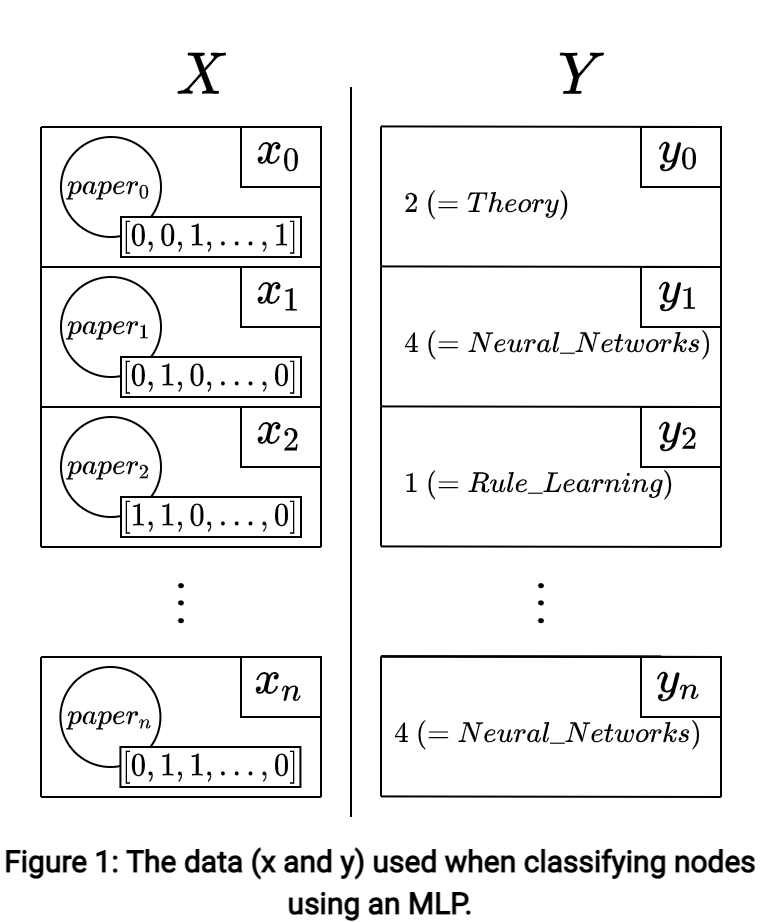
</div>

Creating this classifier is straightforward: we define a torch.nn.Module
consisting of a few dense layers. In the forward pass, we simply propagate x
(our nodes / word-occurence vectors) through these layers to predict the
category.

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        self.lin1 = Linear(num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.lin1(x)  # dense layer outputting (x_size, hidden_channels)
        x = x.relu()  # apply an activation function
        x = F.dropout(x, p=0.7, training=self.training)  # apply (a high) dropout, as we will train on few datapoints
        x = self.lin2(x)  # dense layer outputting (x_size, num_classes): the (one-hot) prediction
        return x

In [ ]:
'''
Training the MLP
'''
model_mlp = MLP(hidden_channels=16)  # initialize our MLP with a hidden size of 16
print(model_mlp)
loss_func = torch.nn.CrossEntropyLoss()  # as this is a classification task, we use CCE
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.01, weight_decay=5e-4)  # Adam usually works well

def train_mlp():
    model_mlp.train()  # set the model to training 'mode' (i.e., apply dropout)
    optimizer.zero_grad()  # set gradients to 0
    out = model_mlp(data.x)  # propagate the data through the model
    loss = loss_func(out[data.train_mask], data.y[data.train_mask])  # compute the loss based on our training mask
    loss.backward()  # derive gradients
    optimizer.step()  # update all parameters based on the gradients
    return loss

def test_mlp(mask):
    model_mlp.eval()  # set the model to evaluation 'mode' (don't use dropout)
    out = model_mlp(data.x)  # propagate the data through the model
    pred = out.argmax(dim=1)  # as prediction, we take the class with the highest probability
    test_correct = pred[mask] == data.y[mask]  # create a tensor that evaluates whether predictions were correct
    test_acc = int(test_correct.sum()) / int(mask.sum())  # get the accuracy
    return test_acc

train_accs = []
test_accs = []
epochs = 50
for epoch in range(1, epochs+1):  # we train for 50 epochs
    loss = train_mlp()  # do one training step over the entire dataset
    train_acc = test_mlp(data.train_mask)  # compute the training accuracy
    test_acc = test_mlp(data.test_mask)  # compute the test accuracy
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    train_accs.append(train_acc)  # save accuracies so we can plot them
    test_accs.append(test_acc)

In [ ]:
'''
To get an overview of the accuracy over the training period, we define a
simple function to plot the saved accuracies.
'''
%matplotlib inline
import matplotlib.pyplot as plt

def plot_train(train_accs, test_accs):
    fig, ax = plt.subplots(figsize=(8,6))
    fnt=16
    ax.plot(train_accs, color='blue', label='Train')
    ax.plot(test_accs, color='red', linestyle='--', label='Test')
    ax.legend(fontsize=fnt)
    ax.tick_params(axis='both', labelsize=fnt)
    ax.set_xlabel('Epoch', fontsize=fnt)
    ax.set_ylabel('Accuracy', fontsize=fnt)

In [ ]:
'''
As is visible, the model massively overfits on the small number of
training datapoints it was shown. The testing accuracy remains stuck at
just above 50%.
'''
plot_train(train_accs, test_accs)

##  Graph Neural Networks
For the GNN, rather than treating the nodes as individual datapoints, we process
them together as a graph. To do so, we will also incorporate the edge data
($edge\_index$) into the model. A simple overview of the data we will use is
provided in Figure 2 below.

<div>
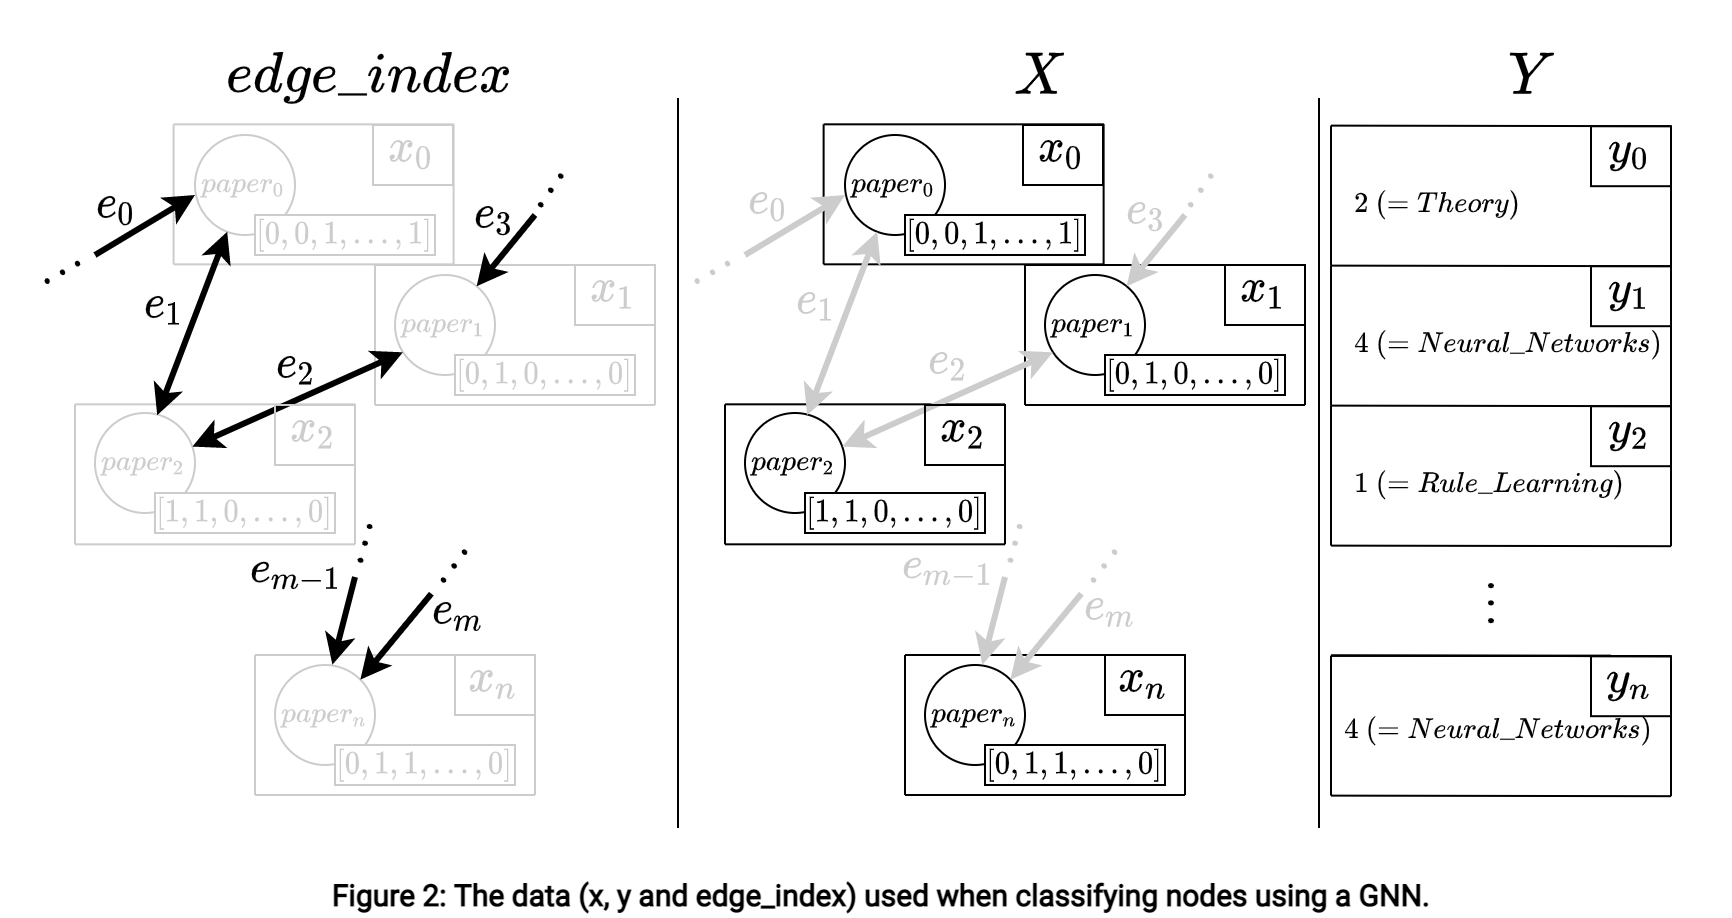
</div>

To treat this dataset as a graph with nodes being defined by **data.x**
($\mathcal{V}$), edges by **data.edge_index** ($\mathcal{E}$) and node-labels in
**data.y** ($f: \mathcal{V} \rightarrow C$), we will use a Graph Neural Network.
The GNNs we consider work according to the neural message passing framework, an
algorithm that describes how node representations can be developed by
propagating node information through the graph.

### Neural Message Passing

Neural Message Passing works by propagating nodes' information to their
neighbors in an iterative manner: for each step, a node's internal state is
updated according to some combination of its own internal state, alongside the
state of its incoming neighbors. As time goes on (more steps are done), the
nodes will be able to 'access' information from nodes increasingly further away
in the graph, as the neighbors' values are determined by nodes increasingly
further away. For a detailed description of this process, we refer to Section
6.4 in the lecture notes. A simple overview of this idea is given in Figure 3
below.

The role of the NN is to learn how to propagate messages (node information)
around the graph. More formally, we can represent the update rule of the message
passing algorithm from iteration $k-1$ to iteration $k$ as follows:

\begin{equation}
x_i^{(k)}=\gamma^{(k)}(x_i^{(k-1)}, \cup_{j\in \mathcal{N}(i)} \phi^{(k)}(x_i^{(k-1)}, x_j^{(k-1)}, e_{j,i}))
\end{equation}

where $\phi$ is the *edge transfer function*, $\cup$ is the *aggregation
function* on the node, $\gamma$ is the *node update function* and
$\mathcal{N}(i)$ is the neighborhood of node $i$. Here, $\phi$ and $\gamma$ are
differentiable functions, such as an MLP, and $\cup$ is a permutation-invariant
aggregation function.

The *edge transfer function* $\phi$ takes the two nodes (from step $k-1$)
corresponding to an edge ($x_i^{(k-1)}$ an $x_j^{(k-1)}$), alongside the edge
information ($e_{j,i}$), and returns the message that should be propagated along
this edge in step $k$.

The *aggregation function* $\cup$ takes all incoming neighbors of $x_i$, indices
${j\in \mathcal{N}(i)}$, and aggregates them according to the result of the
corresponding edge transfer function for these nodes/edges, for step $k$.

The *node update function* $\gamma$ takes the current node information
$x_i^{(k-1)}$, alongside the result of the aggregation function, and updates the
value of node $x_i$ for step $k$.


### GraphSAGE
Many variants of GNNs exist, often conforming to this abstract update rule. The
GNN-variant we consider for this tutorial is GraphSAGE[[2]](#hamilton2017).
GraphSAGE's update rule, described from the ground up, is as follows:

For $\phi$: The edge transfer function is trivial. Edge information is not take
into account, the node-embedding of the edge's source is propagated:

\begin{equation}
 \phi^{(k)}(x_i^{(k-1)}, x_j^{(k-1)}, e_{j,i}) = x_j^{(k-1)}
\end{equation}

For $\cup$: The aggregation function is the mean over all incoming edges, which
in this case is all incoming neighbors ([[2]](#hamilton2017) also propose
different aggregators - $mean$ is used in the PyTorch Geometric implementation):

\begin{equation}
\cup_{j\in \mathcal{N}(i)} = mean_{j\in \mathcal{N}(i)}(x_j^{k-1})
\end{equation}

Note that [[2]](#hamilton2017) propose not using all incoming edges, but rather
sampling a number of edges from the neighborhood (at each step): their
definition of $\mathcal{N}(i)$ slightly deviates from the (default) PyTorch
Geometric implementation, which simply takes all neighbors. For more information
on GraphSAGE's sampling procedure, we refer to Section 3.1 of the paper.

For $\gamma$: The node update function concatenates the aggregation result with
the node's current state and transforms it using a weight matrix with
parameters $\theta^k$, which can be interpreted as a dense layer. After this
operation, the result is put through a non-linear activation function. The
resulting formula is as follows:

\begin{equation}
x_i^{(k)}=\gamma^{(k)} = \sigma\Big(W_{\theta^k}\cdot concatenate(x_i^{(k-1)}, mean_{j\in \mathcal{N}(i)}(x_j^{k-1}))\Big)
\end{equation}

Which specifies the entire update rule. Weight matrix $W_{\theta^k}$ is
parametrized in the same manner as any weight in an NN is learned, and $\sigma$
is a non-linear activation, such as ReLU. Note that the PyTorch Geometric
implementation of this layer does not apply an activation function, we must
apply it ourselves.

The message passing algorithm and GraphSAGE are implemented by PyTorch Geometric, allowing us to easily build a GNN. We can simply create a GNN-layer (or Graph Convolution), which indicates one step in the neural message passing algorithm. Implementation-wise, it is similar to passing data $x$ through any arbitrary layer, however, we must also provide the $edge\_index$, as these two tensors are necessary to define the entire graph.

We construct our model by subclassing torch.nn.Module. We create a network with two message passing steps: We import the GraphSAGE update layer, SAGEConv, and initialize 2 such layers. The forward pass then consists of propagating $x$ and the $edge\_index$ through each graph layer, and applying any other desired activations/transformations to $x$.

The steps in the model correspond to the steps in Figure 3, to give a simple overview of the 'range' of information being spread around the graph.

In [ ]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels)  # the node's word vector (with size num_features) is
                                                              # transformed to a vector of size hidden_channels

        self.conv2 = SAGEConv(hidden_channels, num_classes)  # we convert our nodes from hidden_channels to num_classes, the
                                                             # last update step turns a node's state into a node-class prediction

    def forward(self, x, edge_index):
        # x = (1), all nodes contain information about itself (x_size, num_features)
        x = self.conv1(x, edge_index) # x = (2), update all nodes for the first time, returning (x_size, hidden_channels)
        x = x.relu()  # activation function
        x = F.dropout(x, p=0.7, training=self.training)  # attempt to combat overfitting, as we only have few labels
        x = self.conv2(x, edge_index)  # x = (3), update all nodes again, returning (x_size, num_classes)
                                       # this final update transforms each node embedding to a class prediction
                                       # we do not apply an activation, as the PyTorch CCE calculation
                                       # takes care of treating this output as 'softmax'.
        return x

<div>
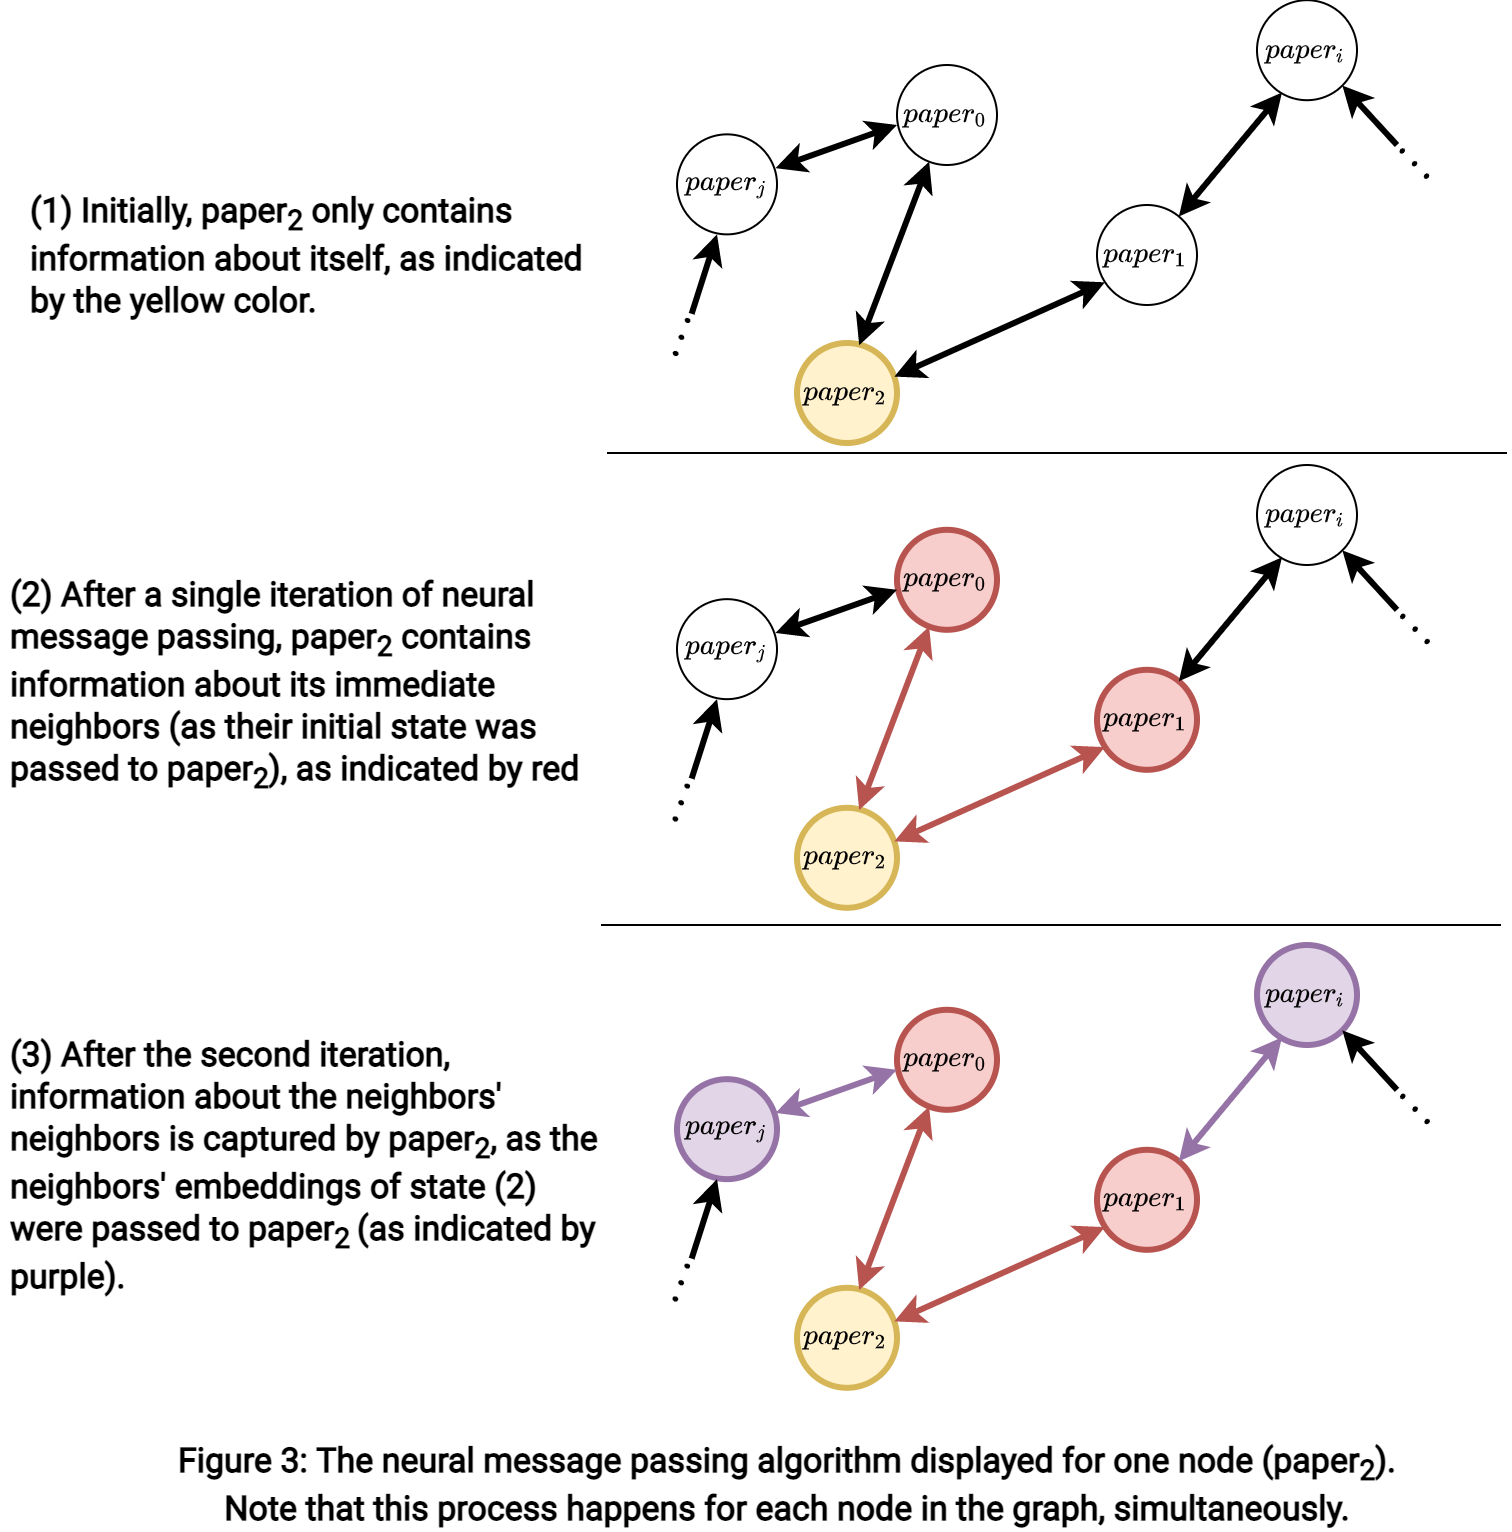
</div>

In [ ]:
'''
Training the GNN
'''
model_gnn = GraphSAGE(hidden_channels=16) # initialize our GNN with a hidden size of 16
print(model_gnn)

# same loss and optimizer as before
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_gnn.parameters(), lr=0.01, weight_decay=5e-4)

def train_gnn():
    model_gnn.train()  # set the model to training 'mode' (i.e., apply dropout)
    optimizer.zero_grad()  # set gradients to 0
    out = model_gnn(data.x, data.edge_index)  # propagate the data through the model
    loss = loss_func(out[data.train_mask], data.y[data.train_mask])  # compute the loss based on our training mask
    loss.backward()  # derive gradients
    optimizer.step()  # update all parameters based on the gradients
    return loss

def test_gnn(mask):
    model_gnn.eval()  # set the model to evaluation 'mode' (don't use dropout)
    out = model_gnn(data.x, data.edge_index)  # propagate the data through the model
    pred = out.argmax(dim=1)  # as prediction, we take the class with the highest probability
    test_correct = pred[mask] == data.y[mask]  # create a tensor that evaluates whether predictions were correct
    test_acc = int(test_correct.sum()) / int(mask.sum())  # get the accuracy
    return test_acc


train_accs = []
test_accs = []
epochs = 50
for epoch in range(1, epochs+1):
    loss = train_gnn()  # do one training step over the entire dataset
    train_acc = test_gnn(data.train_mask)  # compute the training accuracy
    test_acc = test_gnn(data.test_mask)  # compute the test accuracy
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    train_accs.append(train_acc)  # save accuracies so we can plot them
    test_accs.append(test_acc)

In [ ]:
'''
While the model still overfits (which is difficult to avoid, given that
we use only 20 labels for each class), the test accuracy significantly
increased, with a test accuracy of just below 80%. Incorporating edge
information increased the accuracy by about 25%!
'''
plot_train(train_accs, test_accs)

# Evaluation and discussion

To finalize this tutorial, we conduct a small evaluation on what the model has
learned. To get an overview of the model's final embeddings, we can plot them
using TSNE[[5]](#tsne), a method for visualizing high-dimensional data in fewer
(in our case 2) dimensions. The function for doing so is provided below.
Additionally, we provide a function to predict individual datapoints.

In [ ]:
idx_to_class

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import cm
from matplotlib.patches import Patch

'''
A function that plots a models embeddings, and colors them either
according to the original labels or the predicted labels. Additionally,
we can highlight individual datapoints in this embedding.
'''
def visualize(y=None, out=None, z=None, hl=None, text_type='idx', return_z=False, color_pred=False):
    if out is None and z is None:
        print('Must supply either model or TSNE output!')
        return
    if (y is None and out is None) or (y is None and color_pred is False):
        print('Must supply either y or calculate y from out!')
        return

    if z is None: # create our embedding if it was not provided
        z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    if y is None and color_pred is True:
        y = out.argmax(dim=1) # if no labels are provided, take the model's output

    # initialize our figure / plotting related settings
    fig, ax = plt.subplots()
    fig.set_size_inches((10, 10))

    ax.set_xticks([])
    ax.set_yticks([])

    colors = list(plt.cm.Paired.colors)[0:num_classes]
    labels = [idx_to_class[i] for i in range(num_classes)]

    c = [colors[i] for i in y]

    s=50
    scatter = ax.scatter(z[:, 0], z[:, 1], s=s, c=c)

    # if we provide node indices to highlight, do so
    if hl is not None:
        hl_z = z[hl]
        hl_y = y[hl]
        c = [colors[i] for i in hl_y]
        scatter_hl = ax.scatter(hl_z[:, 0], hl_z[:, 1], s=s, c=c, edgecolor='black')
        for i, h_i in enumerate(hl):  # and mark them, so we can find our nodes
            plt.arrow(hl_z[i, 0], hl_z[i, 1]-10, 0, 9, length_includes_head=True, alpha=1, head_width=2, color='black')
            if text_type == 'idx':  # either display the node's idx
                text = str(h_i)
            elif text_type == 'title':  # or the paper's title
                limit = 80
                # text = paper_information[idx_to_idx_true[h_i]]['title']
                if len(text) > limit:
                    text = text[:limit-3] + '...'
            plt.text(hl_z[i, 0]-.1, hl_z[i, 1]-10.5, text, horizontalalignment='center', verticalalignment='top', fontsize=10,
                    bbox=dict(facecolor='gray', alpha=0.3, edgecolor='black', pad=1.0))

    # create our legend
    handles = [Patch(color=c, label=l) for c, l in zip(colors, labels)]
    ax.legend(handles=handles)
    plt.show()

    # rescale the cell this is ran on, and center-align the output
    display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 750})'))
    display(HTML("""<style>#output-body {display: flex;align-items: center;justify-content: center;}</style>"""))

    if return_z:
        return z

def predict_paper(e_idx):
    prediction = int(out[e_idx].argmax())
    true = int(data.y[e_idx])
    prediction_class = idx_to_class[prediction]
    print('Predicted:', idx_to_class[prediction])
    print('True:     ', idx_to_class[true])

In [ ]:
out = model_gnn(data.x, data.edge_index)  # get node embeddings from the GNN
z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())  # and create a TSNE visualization

In [ ]:
# visualize the embeddings of the model, colored by the original labels
visualize(z=z, y=data.y, hl=[7], text_type='idx')

As we can see from the plot, the model's embedding splits the nodes by class quite well.

In [ ]:
# visualize the embeddings of the model, colored by the predicted labels
visualize(z=z, out=out, color_pred=True, hl=[7], text_type='idx')

The predicted labels result in less noisy groups, as is to be expected given
that the node embeddings directly correspond to the predicted labels.

In [ ]:
# example of predicting a single datapoint, alongside some of its metadata
predict_paper(7)
print()
print_paper(7)

## Discussion
In this notebook we've discussed GNNs and applied them to the problem of
classifying papers according to their category. One thing to note is that these
category labels are somewhat ambiguous; what makes a paper a Neural Network
paper opposed to a Reinforcement Learning paper, for example, is difficult to
objectively define. As such, we must take the performance with a grain of salt.
Nevertheless, this dataset served as a nice demonstration for the utility of
modeling a dataset as a graph.

Furthermore, you might have noticed that we did not use any form of minibatching
in this tutorial, but rather passed the entire dataset through the model. This
is on purpose, as minibatching (when considering one big graph) is non-trivial:
If, when checking a certain node, some neighbors are not in the batch, we cannot
process its embeddings (and their neighbors', and so on). A host of methods
exist to deal with these issues (of which GraphSAGE[[2]](#hamilton2017)
introduces one!), but we consider this to lie out of the scope of this tutorial.

To conclude, we credit the Node Classification tutorial provided by PyTorch
Geometric[[4]](#pytorchgeom) as a foundation for this tutorial.

# References
<a name="pytorchgeomintro"></a>
[1] https://pytorch-geometric.readthedocs.io/en/latest/index.html

<a name="hamilton2017"></a>
[2] Hamilton, W. L., Ying, R., & Leskovec, J. (2017, December). Inductive representation learning on large graphs. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 1025-1035).

<a name="cora"></a>
[3] https://relational.fit.cvut.cz/dataset/CORA

<a name="pytorchgeom"></a>
[4] https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html

<a name="tsne"></a>
[5] https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html